This notebook functionizes the 'Array to ASPA'. Goal is to convert any input dictionary to a usable ASPA for analysis.

IMPORTANT:
During the visualisation of the images. Each cmap per individual image is scaled depending on the contents. Therefor the images array has to be saved and used... Saving the PNG's will give faulty results. 

TODO:
Split up all features into e.g. 4 scales so they can be scaled and distuingished better?
But also reserve space for 'cloud' models. 

# Imports

In [4]:
import numpy as np
import seaborn as sns
import pandas as pd


import matplotlib.pyplot as plt

from sklearn.preprocessing import MinMaxScaler
from tqdm import tqdm

from keijzer_exogan import *

%matplotlib inline
%config InlineBackend.print_figure_kwargs={'facecolor' : "w"} # Make sure the axis background of plots is white, this is usefull for the black theme in JupyterLab
sns.set()

# Load chunk
X[0] is a dict from regular chunk  
X[0][0] is a dict from .npy selection  

In [5]:
dir_ = '/datb/16011015/ExoGAN_data//'

X = np.load(dir_+'selection/last_chunks_25_percent.npy')
X = X.flatten()

np.random.seed(23) # Set seed for the np.random functions

# Shuffle X along the first axis to make the order of simulations random
np.random.shuffle(X) # note that X = np.rand.... isn't required

len(X)

1250000

In [6]:
X[0].keys()

dict_keys(['data', 'param'])

In [7]:
# scale the data
def scale_param(X, X_min, X_max):
    """
    Formule source: 
    https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.MinMaxScaler.html
    
    In this case 1 is max, 0 is min
    """
    std = (X-X_min)/ (X_max - X_min)
    return std*(1 - 0)+0

In [8]:
x = X[0]

In [9]:
cmap = 'gray'

"""
Transforms the input dictionary (in the format of ExoGAN), to the ASPA format.
TODO:

- devide each parameter in bins and scale the data per bin (to hopefully increase the contrast in the data)
- make sure to leave space for cloud model information (max2, min2 is currently double info from max1, min1)
"""

spectrum = x['data']['spectrum']

if len(spectrum) != 515:
    print('Spectrum length != 515. breaking script')
    #break

"""
Scale the spectrum
"""
spectrum = spectrum.reshape(-1, 1) # convert 1D array to 2D cause standardscaler requires it

scaler = MinMaxScaler(feature_range=(0,1)).fit(spectrum)
std = np.std(spectrum)
min_ = spectrum.min()
max_ = spectrum.max()

spectrum = scaler.transform(spectrum)

# fill spectrum to have a size of 529, to then reshape to 23x23
spectrum = np.append(spectrum, [0 for _ in range(14)]) # fill array to size 529 with zeroes
spectrum = spectrum.reshape(23, 23) # building block one

# Also scale min_ max_ from the spectrum
min_ = scale_param(min_, 6.5e-3, 2.6e-2)
max_ = scale_param(max_, 6.5e-3, 2.6e-2)

"""
Add the different building blocks to each other
"""

max1 = np.full((12,6), max_) # create array of shape 12,6 (height, width) with the max_ value
min1 = np.full((11,6), min_)
max1min1 = np.concatenate((max1, min1), axis=0) # Add min1 below max1 (axis=0) 

image = np.concatenate((spectrum, max1min1), axis=1) # Add max1min1 to the right of spectrum (axis=1)

"""
Get all parameters and scale them
"""
# Get the param values
ch4 = x['param']['ch4_mixratio']
co2 = x['param']['co2_mixratio']
co = x['param']['co_mixratio']
h2o = x['param']['h2o_mixratio']
mass = x['param']['planet_mass']
radius = x['param']['planet_radius']
temp = x['param']['temperature_profile']

# Scale params (parm, min_value, max_value) where min/max should be the 
ch4 = scale_param(ch4, 1e-8, 1e-1)
co2 = scale_param(co2, 1e-8, 1e-1)
co = scale_param(co, 1e-8, 1e-1)
h2o = scale_param(h2o, 1e-8, 1e-1)
mass = scale_param(mass, 1.5e27, 3.8e27)
radius = scale_param(radius, 5.6e7, 1.0e8)
temp = scale_param(temp, 1e3, 2e3)

# Create the building blocks
co2 = np.full((23,1), co2)
co = np.full((23,1), co)
ch4 = np.full((23,1), ch4)


mass = np.full((1,23), mass)
radius = np.full((1,23), radius)
temp = np.full((1,23), temp)

h2o = np.full((9,9), h2o)

max2 = np.full((6,12), max_) # create array of shape 12,7 (height, width) with the max_ value
min2 = np.full((6,11), min_)

"""
Put building blocks together
"""
image = np.concatenate((image, co2), axis=1)
image = np.concatenate((image, co), axis=1)
image = np.concatenate((image, ch4), axis=1)

sub_image = np.concatenate((max2, min2), axis=1)
sub_image = np.concatenate((sub_image, mass), axis=0)
sub_image = np.concatenate((sub_image, radius), axis=0)
sub_image = np.concatenate((sub_image, temp), axis=0)
sub_image = np.concatenate((sub_image, h2o), axis=1)

image = np.concatenate((image, sub_image), axis=0)

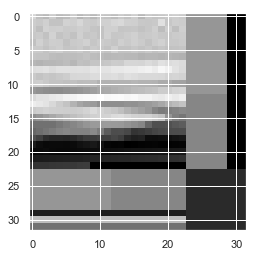

In [10]:
plt.imshow(image, cmap='gray')

# New ASPA

## Load data, combine $(R_p/R_s)^2$ with the wavelength

In [11]:
i = np.random.randint(0,len(X))
x = X[i] # select a dict from X


wavelengths = pd.read_csv(dir_+'wnw_grid.txt', header=None).values
spectrum = x['data']['spectrum']
spectrum = np.expand_dims(spectrum, axis=1) # change shape from (515,) to (515,1)
params = x['param']

for param in params:
    if 'mixratio' in param: 
        params[param] = np.log(np.abs(params[param])) # transform mixratio's because they are generated on logarithmic scale

params

{'planet_mass': 3.796e+27,
 'temperature_profile': 1444.4444444444443,
 'ch4_mixratio': -11.25708267685978,
 'planet_radius': 66803844.44444445,
 'h2o_mixratio': -5.884384126540339,
 'co2_mixratio': -5.884384126540339,
 'co_mixratio': -14.838881710406072}

# Normalize params

In [12]:
# Min max values from training set, in the same order as params above: planet mass, temp, .... co mixratio.
min_values = [1.518e26, 1e3, -18.42, 5.593e7, -18.42, -18.42, -18.42]
max_values = [3.796e27, 2e3, -2.303, 1.049e8, -2.306, -2.306, -2.306]

for i,param in enumerate(params):
    params[param] = scale_param(params[param], min_values[i], max_values[i])

params

{'planet_mass': 1.0,
 'temperature_profile': 0.44444444444444436,
 'ch4_mixratio': 0.4444324206204766,
 'planet_radius': 0.2220511424227986,
 'h2o_mixratio': 0.7779332179135945,
 'co2_mixratio': 0.7779332179135945,
 'co_mixratio': 0.2222364583339909}

In [13]:
wavelengths.shape, spectrum.shape

((515, 1), (515, 1))

In [14]:
data = np.concatenate([wavelengths,spectrum], axis=1)
data = pd.DataFrame(data)
data.columns = ['x', 'y'] # x is wavelength, y is (R_p / R_s)^2

## Original ExoGAN simulation
From 0.3 to 50 micron

515

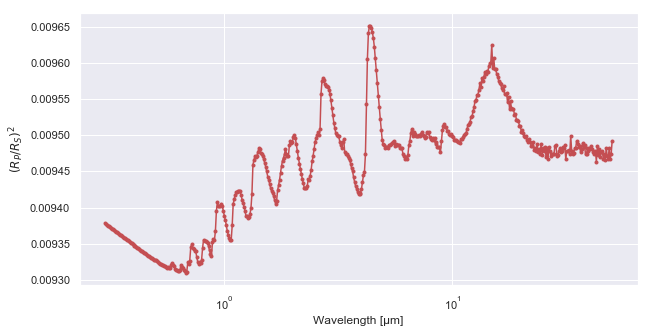

In [15]:
plt.figure(figsize=(10,5))

plt.plot(data.x, data.y, '.-', color='r')
plt.xlabel(r'Wavelength [µm]')
plt.ylabel(r'$(R_P / R_S)^2$')

plt.xscale('log')
len(data)

## Select 0.3 to 16 micron

400

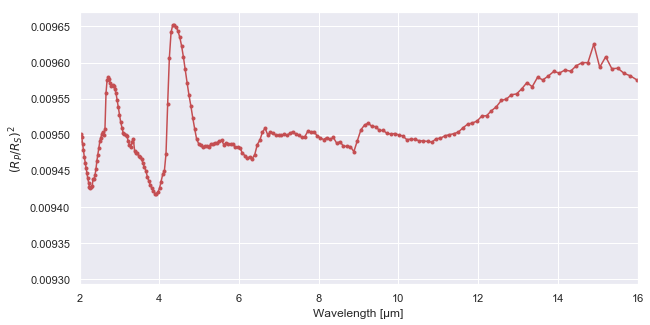

In [16]:
data = data[(data.x >= 0.3) & (data.x <= 16)] # select data between 0.3 and 16 micron

plt.figure(figsize=(10,5))

plt.plot(data.x, data.y, '.-', color='r')
plt.xlabel(r'Wavelength [µm]')
plt.ylabel(r'$(R_P / R_S)^2$')

#plt.xscale('log')
plt.xlim((2, 16))
len(data)

## Important!
Notice how $(R_p/R_s)^2$ by index goes from a high to a low wavelength.  
Apart from that, i'm assuming the spatial difference between peaks is due to plotting against the index instead of the wavelength.  
The spectrum (below) will remain unchanged and is encoded this way into an ASPA, the wavelength values from above therefor have to be used to transform the ASPA back into $(R_p/R_s)^2$ with the wavelength values.  

Text(0, 0.5, '$(R_P / R_S)^2$')

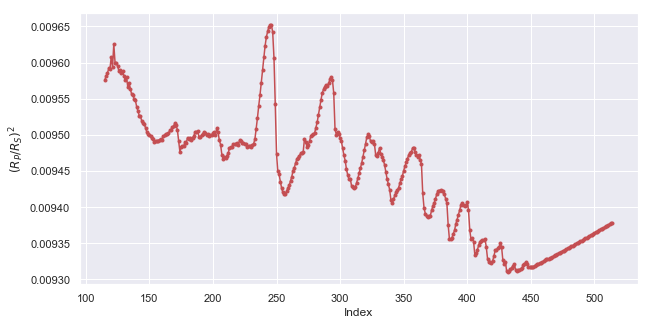

In [17]:
#spectrum = np.flipud(data.y)

plt.figure(figsize=(10,5))

plt.plot(data.y, '.-', color='r')
plt.xlabel(r'Index')
plt.ylabel(r'$(R_P / R_S)^2$')

## Split the spectrum in bins 

In [18]:
# Could loop this, but right now this is more visual
bin1 = data[data.x <= 0.8]
bin2 = data[(data.x > 0.8) & (data.x <= 1.3)] # select data between 2 and 4 micron
bin3 = data[(data.x > 1.3) & (data.x <= 2)]
bin4 = data[(data.x > 2) & (data.x <= 4)]
bin5 = data[(data.x > 4) & (data.x <= 6)]
bin6 = data[(data.x > 6) & (data.x <= 10)]
bin7 = data[(data.x > 10) & (data.x <= 14)]
bin8 = data[data.x > 14]

bin1.head()

,x,y
416,0.799433,0.009328
417,0.791518,0.009323
418,0.783681,0.009324
419,0.775922,0.009322
420,0.768239,0.009325


## Bins against wavelength

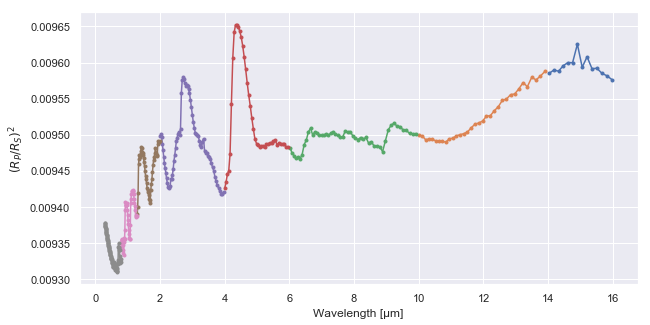

In [19]:
"""
Visualize the bins
"""

bins = [bin8, bin7, bin6, bin5, bin4, bin3, bin2, bin1]

plt.figure(figsize=(10,5))
for b in bins:
    plt.plot(b.iloc[:,0], b.iloc[:,1], '.-')
    plt.xlabel(r'Wavelength [µm]')
    plt.ylabel(r'$(R_P / R_S)^2$')
    
#plt.xlim((0.3, 9))

# Bins against index
Notice how bin1 (0-2 micron) has way more datapoints than bin 8 (14-16 micron)

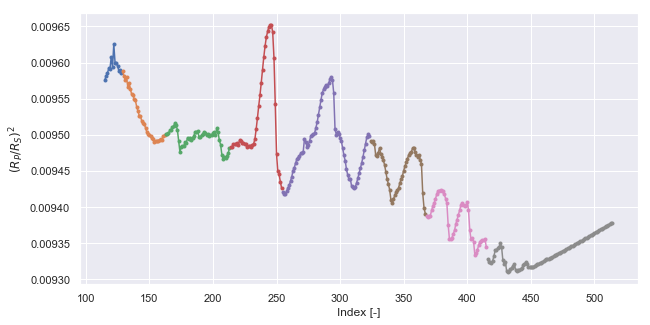

In [20]:
plt.figure(figsize=(10,5))
for b in bins:
    plt.plot(b.iloc[:,1], '.-')
    plt.xlabel(r'Index [-]')
    plt.ylabel(r'$(R_P / R_S)^2$')

## Normalize the spectrum in bins

In [21]:
scalers = [MinMaxScaler(feature_range=(0,1)).fit(b) for b in bins] # list of 8 scalers for the 8 bins
mins = [ b.iloc[:,1].min() for b in bins] # .iloc[:,1] selects the R/R (y) only
maxs = [ b.iloc[:,1].max() for b in bins]
stds = [ b.iloc[:,1].std() for b in bins]

In [ ]:
bins_scaled = []
for i,b in enumerate(bins):
    bins_scaled.append(scalers[i].transform(b))

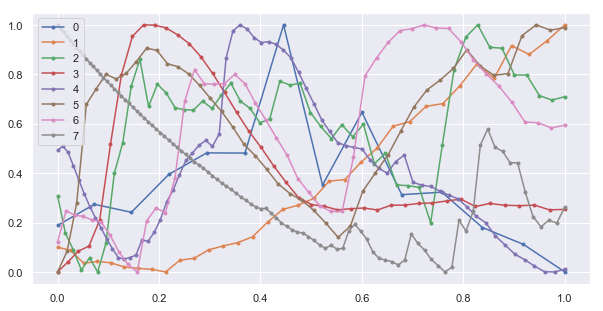

In [ ]:
plt.figure(figsize=(10,5))
for i,b in enumerate(bins_scaled):
    plt.plot(b[:, 0], b[:,1], '.-', label=i)
plt.legend()

In [ ]:
np.concatenate(bins_scaled, axis=0).shape

(400, 2)

## Scaled spectrum in bins

400

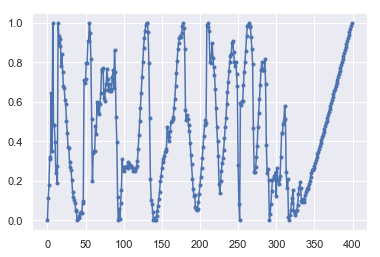

In [ ]:
spectrum_scaled = np.concatenate(bins_scaled, axis=0)
spectrum_scaled = spectrum_scaled[:,1]

plt.plot(spectrum_scaled, '.-')

len(spectrum_scaled)

# Start creating the ASPA

In [ ]:
import math

Using 16 rows


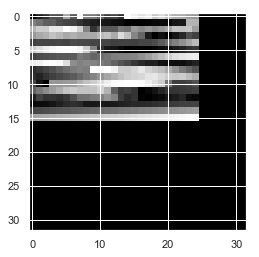

In [ ]:
aspa = np.zeros((32,32))

row_length = 25 # amount of pixels used per row
n_rows = math.ceil(len(spectrum_scaled) / row_length) # amount of rows the spectrum needs in the aspa, so for 415 data points, 415/32=12.96 -> 13 rows
print('Using %s rows' % n_rows)

for i in range(n_rows): # for i in 

    start = i*row_length
    stop = start+row_length
    spec = spectrum_scaled[start:stop]
    
    if len(spec) != row_length:
        n_missing_points = row_length-len(spec)
        spec = np.append(spec, [0 for _ in range(n_missing_points)]) # for last row, if length != 32, fill remaining with 0's
        print('Filled row with %s points' % n_missing_points)
        
    aspa[i, :row_length] = spec

plt.imshow(aspa, cmap='gray')

# Fill in the 7 ExoGAN params

In [ ]:
params

{'planet_mass': 1.0,
 'temperature_profile': 0.44444444444444436,
 'ch4_mixratio': 0.4444324206204766,
 'planet_radius': 0.2220511424227986,
 'h2o_mixratio': 0.7779332179135945,
 'co2_mixratio': 0.7779332179135945,
 'co_mixratio': 0.2222364583339909}

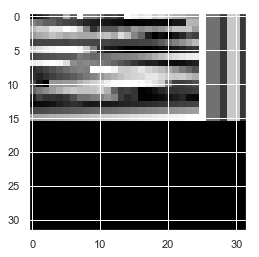

In [ ]:
for i,param in enumerate(params):
    aspa[:16, 25+i:32+i] = params[param]

plt.imshow(aspa, cmap='gray')

# Fill in the min, max, std valued for the bins
TODO: Normalize these properly

In [ ]:
mins, maxs, stds

([0.009576052351924871,
  0.00948969038791038,
  0.009466675486664744,
  0.009425887453864511,
  0.009418250639493905,
  0.009390680453811062,
  0.009333122945417178,
  0.009309788259927995],
 [0.009625448551955067,
  0.009587675795595585,
  0.009515872804872212,
  0.009652258867695551,
  0.009579469308764136,
  0.009491772188964286,
  0.009423597954715137,
  0.00937811103644907],
 [1.2256046228634032e-05,
  3.258250849671336e-05,
  1.2329180499600768e-05,
  6.720852018687742e-05,
  4.604926867285407e-05,
  2.7977919600406793e-05,
  2.7503860286982162e-05,
  1.9591670112659165e-05])

0.18304209407699484 0.18501794207820269 0.12168214443077108
0.1795876155164152 0.18350703182382339 0.3251502352023359
0.17866701946658978 0.1806349121948885 0.1224142192152229
0.17703549815458045 0.18609035470782206 0.6717569588276018
0.17673002557975623 0.18317877235056546 0.4599526393679086
0.17562721815244248 0.17967088755857144 0.27905825425832625
0.17332491781668713 0.1769439181886055 0.27431291578560724
0.17239153039711982 0.17512444145796277 0.1951118129395312


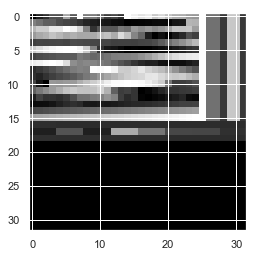

In [ ]:
for i in range(len(mins)):
    min_ = scale_param(mins[i], 0.005, 0.03)
    max_ = scale_param(maxs[i], 0.005, 0.03)
    std_ = scale_param(stds[i], 1e-7, 1e-4)
    
    aspa[16:17, i*4:i*4+4] = min_
    aspa[17:18, i*4:i*4+4] = std_
    aspa[18:19, i*4:i*4+4] = max_
    
    
    print(min_, max_, std_)

plt.imshow(aspa, cmap='gray')

# Fill in unused space with noise

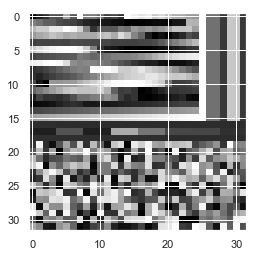

In [ ]:
for i in range(13):
    noise = np.random.rand(32) # random noise betweem 0 and 1 for each row
    aspa[19+i:20+i*1, :] = noise

plt.imshow(aspa, cmap='gray')

# Functionize ASPA v2

In [ ]:
def ASPA_v2(x, wavelengths):
    spectrum = x['data']['spectrum']
    spectrum = np.expand_dims(spectrum, axis=1) # change shape from (515,) to (515,1)
    params = x['param']

    for param in params:
        if 'mixratio' in param: 
            params[param] = np.log(np.abs(params[param])) # transform mixratio's because they are generated on logarithmic scale
    
    """
    Normalize params
    """
    # Min max values from training set, in the same order as params above: planet mass, temp, .... co mixratio.
    min_values = [1.518e26, 
                  1e3, 
                  -18.42, 
                  5.593e7, 
                  -18.42, 
                  -18.42, 
                  -18.42]
    
    max_values = [3.796e27, 
                  2e3, 
                  -2.303, 
                  1.049e8, 
                  -2.306, 
                  -2.306,
                  -2.306]

    for i,param in enumerate(params):
        params[param] = scale_param(params[param], min_values[i], max_values[i])
        #print('%s: %s' % (param, params[param]))
    #print('-'*5)
    """
    Select bins
    """
    data = np.concatenate([wavelengths,spectrum], axis=1)
    data = pd.DataFrame(data)
    data.columns = ['x', 'y'] # x is wavelength, y is (R_p / R_s)^2
    
    # Could loop this, but right now this is more visual
    bin1 = data[data.x <= 0.8]
    bin2 = data[(data.x > 0.8) & (data.x <= 1.3)] # select data between 2 and 4 micron
    bin3 = data[(data.x > 1.3) & (data.x <= 2)]
    bin4 = data[(data.x > 2) & (data.x <= 4)]
    bin5 = data[(data.x > 4) & (data.x <= 6)]
    bin6 = data[(data.x > 6) & (data.x <= 10)]
    bin7 = data[(data.x > 10) & (data.x <= 14)]
    bin8 = data[data.x > 14]

    bins = [bin8, bin7, bin6, bin5, bin4, bin3, bin2, bin1]
    
    """
    Normalize bins
    """
    scalers = [MinMaxScaler(feature_range=(0,1)).fit(b) for b in bins] # list of 8 scalers for the 8 bins
    mins = [ b.iloc[:,1].min() for b in bins] # .iloc[:,1] selects the R/R (y) only
    maxs = [ b.iloc[:,1].max() for b in bins]
    stds = [ b.iloc[:,1].std() for b in bins]
    #print(min(mins), max(maxs))
    bins_scaled = []
    for i,b in enumerate(bins):
        bins_scaled.append(scalers[i].transform(b))
        
    spectrum_scaled = np.concatenate(bins_scaled, axis=0)
    spectrum_scaled = spectrum_scaled[:,1]
    
    """
    Create the ASPA
    """
    
    """Spectrum"""
    aspa = np.zeros((32,32))

    row_length = 25 # amount of pixels used per row
    n_rows = math.ceil(len(spectrum_scaled) / row_length) # amount of rows the spectrum needs in the aspa, so for 415 data points, 415/32=12.96 -> 13 rows
    #print('Using %s rows' % n_rows)

    for i in range(n_rows): # for i in 

        start = i*row_length
        stop = start+row_length
        spec = spectrum_scaled[start:stop]

        if len(spec) != row_length:
            n_missing_points = row_length-len(spec)
            spec = np.append(spec, [0 for _ in range(n_missing_points)]) # for last row, if length != 32, fill remaining with 0's
            #print('Filled row with %s points' % n_missing_points)

        aspa[i, :row_length] = spec
        
    """ExoGAN params"""
    for i,param in enumerate(params):
        aspa[:16, 25+i:26+i] = params[param]
        
    """min max std values for spectrum bins"""
    for i in range(len(mins)):
        min_ = scale_param(mins[i], 0.005, 0.03)
        max_ = scale_param(maxs[i], 0.005, 0.03)
        std_ = scale_param(stds[i], 9e-6, 2e-4)

        aspa[16:17, i*4:i*4+4] = min_
        aspa[17:18, i*4:i*4+4] = std_
        aspa[18:19, i*4:i*4+4] = max_
        
    """Fill unused space with noice"""
    for i in range(13):
        noise = np.random.rand(32) # random noise betweem 0 and 1 for each row
        aspa[19+i:20+i*1, :] = noise
        
    return aspa

# Test ASPA v2 function

In [ ]:
## Load data

In [ ]:
i = np.random.randint(0,len(X))
dict_ = X[i] # select a dict from X

wavelengths = pd.read_csv(dir_+'wnw_grid.txt', header=None).values

dict_['param']

{'planet_mass': 1.5184e+27,
 'temperature_profile': 1444.4444444444443,
 'ch4_mixratio': 0.0027825594022071257,
 'planet_radius': 66803844.44444445,
 'h2o_mixratio': 0.0027825594022071257,
 'co2_mixratio': 5.99484250318941e-08,
 'co_mixratio': 5.99484250318941e-08}

In [ ]:
aspa = ASPA_v2(dict_, wavelengths)

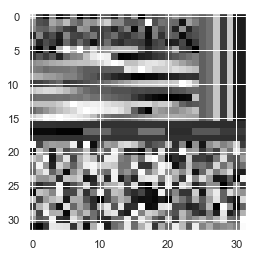

In [ ]:
plt.imshow(aspa, cmap='gray')

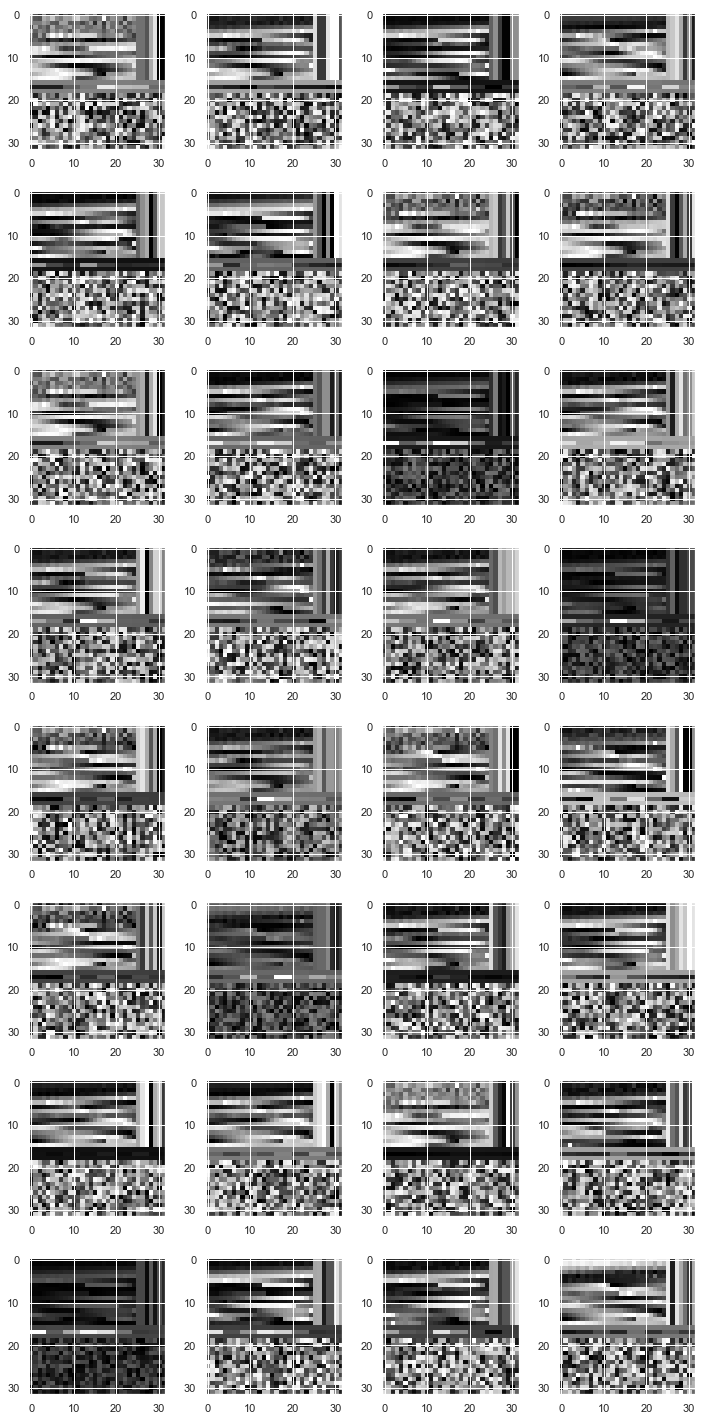

In [ ]:
plt.figure(figsize=(10,20))

for i in range(8*4):
    image = ASPA_v2(X[i], wavelengths)
    

    plt.subplot(8, 4, i+1)
    plt.imshow(image, cmap='gray')
    plt.tight_layout()

# Creating images from all simulations in the chunk

In [ ]:
images = []
for i in tqdm(range(len(X))):
    image = ASPA_v2(X[i], wavelengths)
    image = image.reshape(1, 32, 32) # [images, channel, width, height]
    images.append(image)
    
images = np.array(images)
images.shape

  6%|▌         | 74786/1250000 [15:21<3:54:42, 83.45it/s]

# Saving this array to disk

In [ ]:
%%time
np.save(dir_+'selection/first_chunks_25_percent_images.npy', images)

# Test loading and visualization

In [ ]:
print('DONE')

In [ ]:
images = np.load('/datb/16011015/ExoGAN_data/selection/last_chunks_25_percent_images.npy')

In [ ]:
images.shape

In [ ]:
plt.imshow(images[0,0,:,:])

In [ ]:
plt.figure(figsize=(10,20))

for i in range(8*4):
    plt.subplot(8, 4, i+1)
    plt.imshow(images[i,0,:,:], cmap='gnuplot2')
    plt.tight_layout()

# Randomly mask pixels from the encoded spectrum

In [ ]:
image = images[0, 0, :, :]
plt.imshow(image)

In [ ]:
# image[:23, :23] is the encoded spectrum.
t = image.copy()
print(t.shape)
#t[:23, :23] = 0
plt.imshow(t)

# Random uniform dropout

In [ ]:
t = image.copy()
dropout = 0.9

for i in range(24): # loop over rows
    for j in range(24): # loop over cols
        a = np.random.random() # random uniform dist 0 - 1
        if a < dropout:
            t[i-1:i, j-1:j] = 0
        else:
            pass

In [ ]:
plt.figure(figsize=(10,10))
plt.imshow(t)

In [ ]:
# image[:23, :23] is the encoded spectrum.
t = image.copy()

#t[:23, :23] = 0
plt.imshow(t)
t.shape

# Range dropout

In [ ]:
# TODO: Mask everything but the visible spectrum

def mask_image(image, visible_length, random_visible_spectrum=True):
    """
    Masks everything in an input image, apart from the start to visible_length. 
    
    start = start wavelength/index value of the visible (non masked) spectrum
    visible_length = length of the visible spectrum (in pixels)
    output: masked_image
    """

    image_masked = image.copy()
    
    spectrum_length = 23*23 # length of spectrum in ASPA
    start_max = spectrum_length - visible_length # maximum value start can have to still be able to show spectrum of length visible_length
    start = np.random.randint(0, start_max)

    # start stop index to mask before the visible (not masked) spectrum / sequence

    stop = start + visible_length # stop index of unmasked sequence

    spectrum = image_masked[:23, :23].flatten() # flatten the spectrum
    spectrum[:start] = 0
    spectrum[stop:] = 0
    spectrum = spectrum.reshape(23, 23)

    #t[:, :] = 0

    image_masked[:23, :23] = spectrum

    image_masked[:, 29:] = 0 # right side params
    image_masked[29:, :] = 0 # bottom params
    image_masked[23:, 23:] = 0 # h2o

    image_masked = image_masked.reshape(1, 32, 32) # add the channel dimension back 
    
    return image_masked


image = images[0, 0, :, :].copy()
visible_length = 46 # length of the visible (not to mask) spectrum

image_masked = mask_image(image, visible_length)
plt.imshow(image_masked[0, :, :])

## Also mask params and h2o
Leaving min max values for now (they will get updated anyway)